# Training Models on ET-Data

This notebook demonstrates how to train different models on the Electricity Transformer (ET) dataset using the CAP framework. We'll cover:
1. Data Loading and Preprocessing,
2. Model Training,
3. Evaluation and Visualization,
4. Comparing Different Models

## Setup

First, let's import the necessary libraries and set up our environment.

In [3]:
import os
import sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
# Add the parent directory to the path if needed
sys.path.append(os.path.abspath('/home/yeqchen/cap/CAP'))

In [6]:
from cap.data.data import get_dataloaders
from cap.training import train_model, evaluate_model
from cap.models import *  # Import all available models


In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [11]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Configuration

In [12]:
# Load Configuration
config_path = '../cap/configs/config_et.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Print configuration
print("Configuration:")
print(f"Dataset: {config['dataset']['path']}")
print(f"Model: {config['model']['type']}")
print(f"Training: {config['training']['epochs']} epochs, {config['training']['device']}")

Configuration:
Dataset: /home/yeqchen/cap/CAP/dataset/ElectricityTransformer/et_data.txt
Model: fdeformer
Training: 50 epochs, cuda


In [13]:
 # You can modify the configuration here if needed
config['model']['type'] = 'transformer'  # Change model type
config['training']['epochs'] = 20  # Change number of epochs

## 2. Data Loading and Preprocessing

Now let's load the ET-data and prepare it for training.

In [16]:
# Get dataloaders
train_loader, valid_loader, test_loader = get_dataloaders(
    path=config['dataset']['path'],
    batch_size=config['dataset']['batch_size'],
    model_type=config['model']['type'],
    normalization=True
    )

In [17]:
# Get input and output dimensions from the first batch
for batch in train_loader:
    inputs, targets = batch
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    seq_len = inputs.shape[1]
    pred_len = targets.shape[1]
    break

print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")
print(f"Sequence length: {seq_len}")
print(f"Prediction length: {pred_len}")


Input dimension: 7
Output dimension: 1
Sequence length: 60
Prediction length: 60


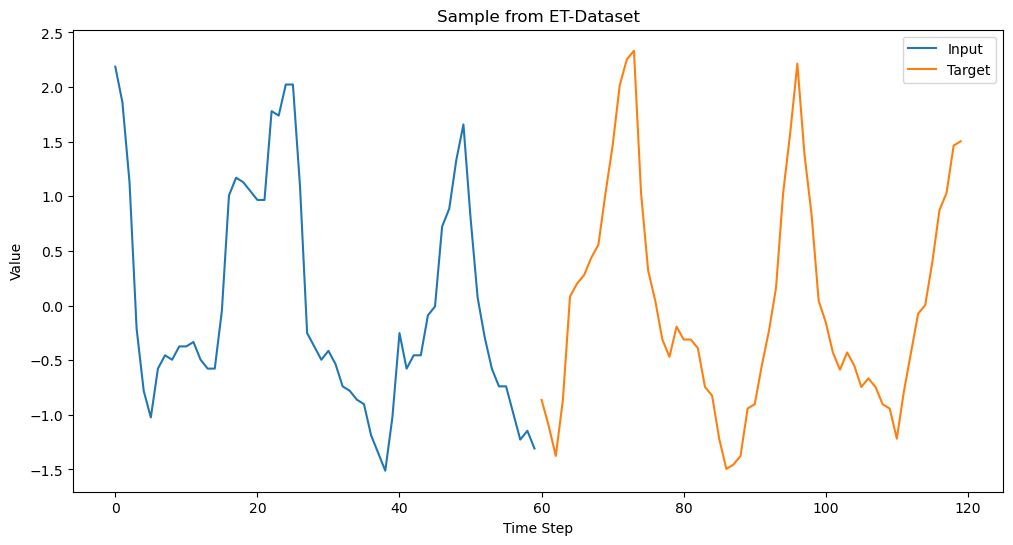

In [19]:
# Visualize a sample from the dataset
plt.figure(figsize=(12, 6))
plt.plot(inputs[0, :, 0].numpy(), label='Input')
plt.plot(range(seq_len, seq_len + pred_len), targets[0, :, 0].numpy(), label='Target')
plt.title('Sample from ET-Dataset')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3. Model Training

Let's train the model using the configuration.

In [20]:
# Train model
model = train_model(
    train_loader=train_loader,
    valid_loader=valid_loader,
    input_dim=input_dim,
    output_dim=output_dim,
    seq_len=seq_len,
    pred_len=pred_len,
    hidden_dim=config['model']['hidden_dim'],
    num_layers=config['model']['num_layers'],
    epochs=config['training']['epochs'],
    lr=config['training']['learning_rate'],
    patience=config['training']['patience'],
    device=config['training']['device'],
    model_type=config['model']['type']
    )

Epoch [1/20] - Train Loss: 3.2965 | Valid Loss: 1.0150
Epoch [2/20] - Train Loss: 1.0059 | Valid Loss: 0.9988
Epoch [3/20] - Train Loss: 0.9999 | Valid Loss: 1.9612
Epoch [4/20] - Train Loss: 1.0150 | Valid Loss: 0.9995
Epoch [5/20] - Train Loss: 1.0042 | Valid Loss: 0.9987
Epoch [6/20] - Train Loss: 1.0032 | Valid Loss: 0.9951
Epoch [7/20] - Train Loss: 0.9507 | Valid Loss: 0.8871
Epoch [8/20] - Train Loss: 0.8903 | Valid Loss: 0.8633
Epoch [9/20] - Train Loss: 0.8712 | Valid Loss: 0.8587
Epoch [10/20] - Train Loss: 0.8566 | Valid Loss: 0.8245
Epoch [11/20] - Train Loss: 0.8407 | Valid Loss: 0.8430
Epoch [12/20] - Train Loss: 0.8369 | Valid Loss: 0.8330
Epoch [13/20] - Train Loss: 0.8292 | Valid Loss: 0.8240
Epoch [14/20] - Train Loss: 0.8271 | Valid Loss: 0.8275
Epoch [15/20] - Train Loss: 0.8205 | Valid Loss: 0.8102
Epoch [16/20] - Train Loss: 0.8170 | Valid Loss: 0.8289
Epoch [17/20] - Train Loss: 0.8039 | Valid Loss: 0.8298
Epoch [18/20] - Train Loss: 0.8071 | Valid Loss: 0.8193
E

In [21]:
# Save model
os.makedirs("saved_models", exist_ok=True)
model_path = f"saved_models/et_{config['model']['type']}_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to saved_models/et_transformer_model.pth


## 4. Evaluation and Visualization

Now let's evaluate the model on the test set and visualize the predictions.

In [23]:
# Evaluate model
mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=config['model']['type'])
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.8502


In [24]:
# Make predictions on test data
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_loader:
        if config['model']['type'] in ['lstm', 'transformer']:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
        else:  # autoformer, informer, fedformer
            x_enc, x_dec, y = batch
            x_enc, x_dec, y = x_enc.to(device), x_dec.to(device), y.to(device)
            outputs = model(x_enc, None, x_dec, None)
            targets = y
            x_enc, x_dec, y = x_enc.to(device), x_dec.to(device), y.to(device)
            outputs = model(x_enc, None, x_dec, None)
            targets = y
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

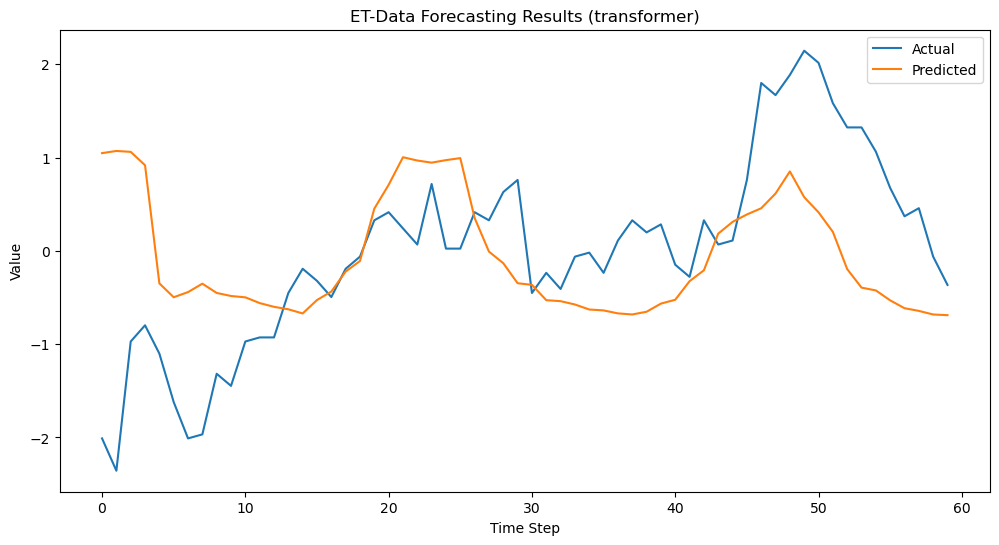

In [25]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actuals[0, :, 0], label='Actual')
plt.plot(predictions[0, :, 0], label='Predicted')
plt.title(f'ET-Data Forecasting Results ({config["model"]["type"]})')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## 5. Comparing Different Models

Let's train and compare different models on the ET-data.


Training lstm model...


Epoch [1/20] - Train Loss: 0.8891 | Valid Loss: 0.8487
Epoch [2/20] - Train Loss: 0.8565 | Valid Loss: 0.8493
Epoch [3/20] - Train Loss: 0.8525 | Valid Loss: 0.8405
Epoch [4/20] - Train Loss: 0.8420 | Valid Loss: 0.8314
Epoch [5/20] - Train Loss: 0.8350 | Valid Loss: 0.8299
Epoch [6/20] - Train Loss: 0.8293 | Valid Loss: 0.8234
Epoch [7/20] - Train Loss: 0.8248 | Valid Loss: 0.8193
Epoch [8/20] - Train Loss: 0.8209 | Valid Loss: 0.8162
Epoch [9/20] - Train Loss: 0.8141 | Valid Loss: 0.8158
Epoch [10/20] - Train Loss: 0.8126 | Valid Loss: 0.8205
Epoch [11/20] - Train Loss: 0.8015 | Valid Loss: 0.8169
Epoch [12/20] - Train Loss: 0.7957 | Valid Loss: 0.8180
Epoch [13/20] - Train Loss: 0.7913 | Valid Loss: 0.8110
Epoch [14/20] - Train Loss: 0.7825 | Valid Loss: 0.8090
Epoch [15/20] - Train Loss: 0.7770 | Valid Loss: 0.8044
Epoch [16/20] - Train Loss: 0.7671 | Valid Loss: 0.8168
Epoch [17/20] - Train Loss: 0.7546 | Valid Loss: 0.8037
Epoch [18/20] - Train Loss: 0.7457 | Valid Loss: 0.7949
E

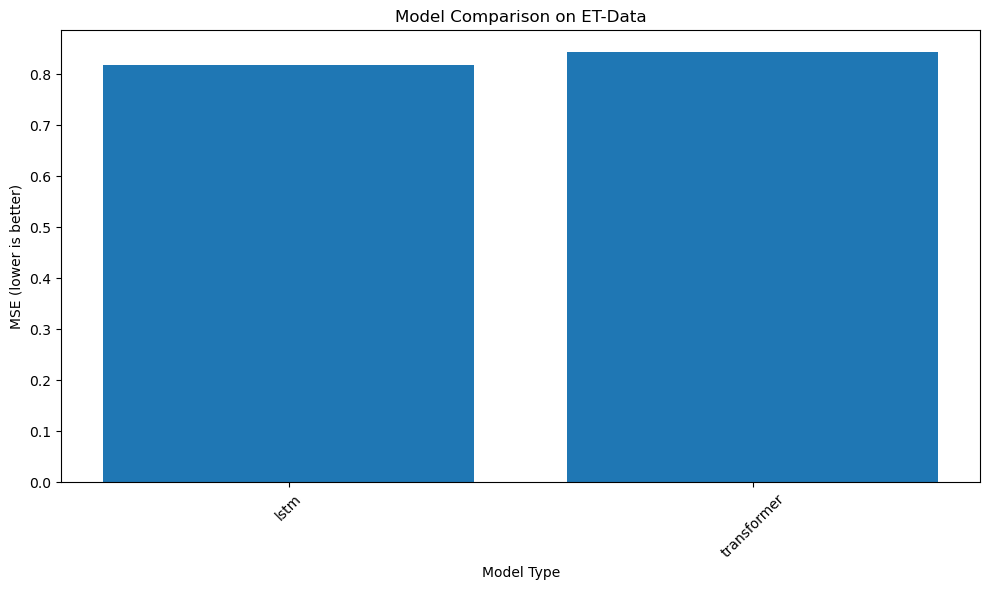

In [29]:
# List of models to compare
model_types = ['lstm', 'transformer']
results = {}

for model_type in model_types:
    print(f"\nTraining {model_type} model...")

    # Update config
    config['model']['type'] = model_type

    # Train model
    model = train_model(
        train_loader=train_loader,
        valid_loader=valid_loader,
        input_dim=input_dim,
        output_dim=output_dim,
        seq_len=seq_len,
        pred_len=pred_len,
        hidden_dim=config['model']['hidden_dim'],
        num_layers=config['model']['num_layers'],
        epochs=config['training']['epochs'],
        lr=config['training']['learning_rate'],
        patience=config['training']['patience'],
        device=config['training']['device'],
        model_type=model_type
    )

    # Evaluate model
    mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=model_type)
    results[model_type] = mse
    print(f"{model_type} Test MSE: {mse:.4f}")
    
    # Save model
    model_path = f"saved_models/et_{model_type}_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison on ET-Data')
plt.xlabel('Model Type')
plt.ylabel('MSE (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Hyperparameter Tuning

Let's experiment with different hyperparameters for the best model.

Best model: lstm with MSE: 0.8177
Tuning hidden_dim = 64...
Epoch [1/20] - Train Loss: 0.9013 | Valid Loss: 0.8523
Epoch [2/20] - Train Loss: 0.8580 | Valid Loss: 0.8442
Epoch [3/20] - Train Loss: 0.8455 | Valid Loss: 0.8442
Epoch [4/20] - Train Loss: 0.8402 | Valid Loss: 0.8380
Epoch [5/20] - Train Loss: 0.8357 | Valid Loss: 0.8298
Epoch [6/20] - Train Loss: 0.8284 | Valid Loss: 0.8267
Epoch [7/20] - Train Loss: 0.8288 | Valid Loss: 0.8245
Epoch [8/20] - Train Loss: 0.8242 | Valid Loss: 0.8228
Epoch [9/20] - Train Loss: 0.8180 | Valid Loss: 0.8232
Epoch [10/20] - Train Loss: 0.8140 | Valid Loss: 0.8161
Epoch [11/20] - Train Loss: 0.8118 | Valid Loss: 0.8162
Epoch [12/20] - Train Loss: 0.8101 | Valid Loss: 0.8123
Epoch [13/20] - Train Loss: 0.8039 | Valid Loss: 0.8105
Epoch [14/20] - Train Loss: 0.8026 | Valid Loss: 0.8063
Epoch [15/20] - Train Loss: 0.7959 | Valid Loss: 0.8001
Epoch [16/20] - Train Loss: 0.7889 | Valid Loss: 0.8038
Epoch [17/20] - Train Loss: 0.7800 | Valid Loss: 0.79

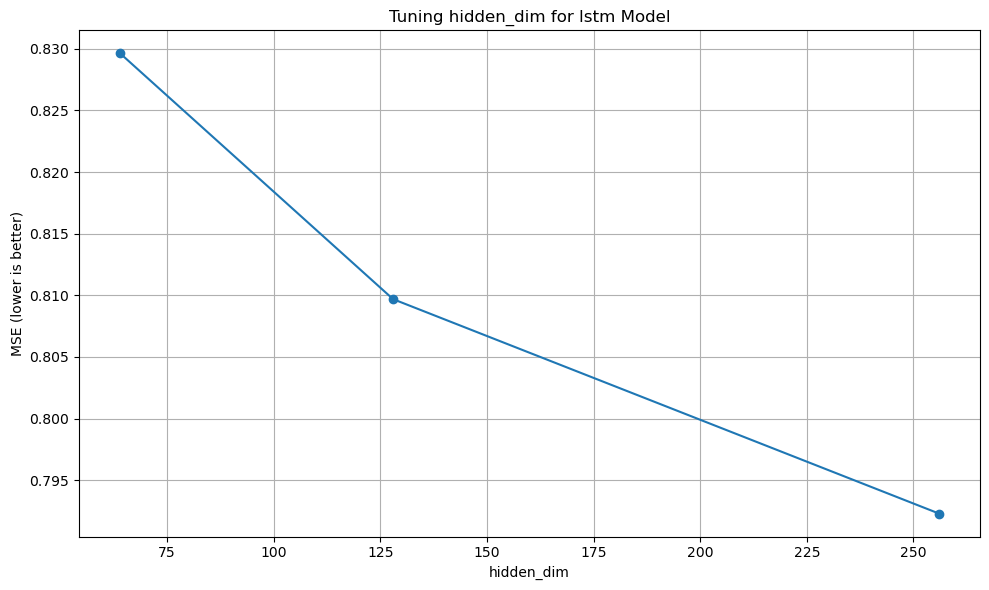

Best hidden_dim: 256 with MSE: 0.7923


In [34]:
# Find the best model
best_model = min(results, key=results.get)
print(f"Best model: {best_model} with MSE: {results[best_model]:.4f}")

# Hyperparameters to tune
hidden_dims = [64, 128, 256]
num_layers_list = [1, 2, 3]
learning_rates = [0.001, 0.0005, 0.0001]

# You can choose which hyperparameters to tune
param_name = 'hidden_dim'  # Options: 'hidden_dim', 'num_layers', 'learning_rate'
param_values = hidden_dims if param_name == 'hidden_dim' else num_layers_list if param_name == 'num_layers' else learning_rates

tuning_results = {}

for value in param_values:
    print(f"Tuning {param_name} = {value}...")
    
    # Update config
    if param_name == 'hidden_dim':
        config['model']['hidden_dim'] = value
    elif param_name == 'num_layers':
        config['model']['num_layers'] = value
    elif param_name == 'learning_rate':
        config['training']['learning_rate'] = value
    
    # Train model
    model = train_model(
        train_loader=train_loader,
        valid_loader=valid_loader,
        input_dim=input_dim,
        output_dim=output_dim,
        seq_len=seq_len,
        pred_len=pred_len,
        hidden_dim=config['model']['hidden_dim'],
        num_layers=config['model']['num_layers'],
        epochs=config['training']['epochs'],
        lr=config['training']['learning_rate'],
        patience=config['training']['patience'],
        device=config['training']['device'],
        model_type=best_model
    )
    
    # Evaluate model
    mse = evaluate_model(model, test_loader, device=config['training']['device'], model_type=best_model)
    tuning_results[value] = mse
    print(f"Test MSE: {mse:.4f}")

# Plot tuning results
plt.figure(figsize=(10, 6))
plt.plot(list(tuning_results.keys()), list(tuning_results.values()), marker='o')
plt.title(f'Tuning {param_name} for {best_model} Model')
plt.xlabel(param_name)
plt.ylabel('MSE (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Find best hyperparameter
best_param = min(tuning_results, key=tuning_results.get)
print(f"Best {param_name}: {best_param} with MSE: {tuning_results[best_param]:.4f}")

## 7. Conclusion

In this notebook, we've:
1. Loaded and preprocessed the ET-data
2. Trained different models on the data
3. Evaluated and visualized the results
4. Compared different model architectures
5. Tuned hyperparameters for the best model

You can now use the best model and hyperparameters for your time series forecasting tasks.